<a href="https://colab.research.google.com/github/Nayoung-young/prj-ecommerce-ltv/blob/main/e_commerce_LTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _0.라이브러리 임포트

In [101]:
!pip install plotly
!pip install Lifetimes
!pip install nb_black

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached nb_black-1.0.7.tar.gz (4.8 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [102]:
import pandas as pd # python에서의 엑셀과 같은 역할
import numpy as np # 계산을 편하게 해 주는 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt # 시각화
import seaborn as sns # 시각화
import math

import matplotlib.ticker as ticker # 시각화
import matplotlib.dates as mdates # 시각화

import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='white')

# from other 
import matplotlib.colors as mcolors
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
%matplotlib inline
sns.set_style('whitegrid')
palette = 'Set2'

# sns.set(font_scale=2)

# _1. 데이터 불러오기 

In [103]:
%%time
df = pd.read_csv('/content/e-commerce_LTV.csv', encoding= 'unicode_escape')
df_base = df.copy()

CPU times: user 979 ms, sys: 298 ms, total: 1.28 s
Wall time: 1.35 s


In [104]:
df_base.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [105]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [106]:
len(df_base['InvoiceNo'].unique().tolist()) # InvoiceNo가 primary key인가? -> Nope 

25900

In [107]:
print(min(df_base['Quantity'].tolist()))
print(max(df_base['Quantity'].tolist())) # Quantity 범위 확인 

-80995
80995


In [108]:
quantity = df_base['Quantity'].tolist() 

print(len(list(filter(lambda x: x < 0, quantity)))) # quantity < 0 인 경우 
print(len(list(filter(lambda x: x > 0, quantity)))) # quantity > 0 인 경우 

10624
531285


In [109]:
sum(df_base['Quantity'].dropna())

5176450

In [110]:
# df_base['Country'].unique().tolist() # Country 고유값

In [111]:
# df_base.groupby(['Country']).agg(country_cnt = ('Country', 'count')).reset_index().sort_values(by = 'country_cnt', ascending =False)

#_1. 데이터 전처리

In [112]:
df_base.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

## 1.1 컬럼명 바꾸기 

In [113]:
# 컬럼 이름 snake case 로 rename 
%%time
df_base.rename(columns = {'InvoiceNo':'invoice_no', 
                        'StockCode':'stock_code', 
                        'Quantity': 'quantity',
                        'Description':'description',
                        'InvoiceDate': 'invoice_date',
                        'UnitPrice': 'unit_price', 
                        'CustomerID': 'customer_id', 
                        'Country':'country'}, inplace = True)

CPU times: user 1.49 ms, sys: 0 ns, total: 1.49 ms
Wall time: 4.52 ms


In [114]:
LTV_columns = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'customer_id']
df_LTV = df_base[LTV_columns]

In [115]:
df_LTV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   quantity      541909 non-null  int64  
 3   invoice_date  541909 non-null  object 
 4   unit_price    541909 non-null  float64
 5   customer_id   406829 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 24.8+ MB


## 1.2 결측값 처리 
- customer_id: 
  - 결측값 = 비회원으로 추정
  - 추후 LTV 계산에서 활용하지는 않을 것이지만 fillna(0)
  - object로 타입 변환 

In [116]:
df_LTV_01 = df_LTV.copy()

In [117]:
## customer_id type 변환해도될지 체크 
%%time 
list(filter(lambda x: str(x)[-1] != '0', df_LTV_01['customer_id'].unique().tolist()))

CPU times: user 15.1 ms, sys: 6.06 ms, total: 21.1 ms
Wall time: 33 ms


[nan]

In [118]:
df_LTV_01['customer_id'].isna().sum() # customer_id 결측값 확인 

135080

In [119]:
df_LTV_01.sample(5)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
410568,C572111,82483,-1,10/20/2011 19:13,6.95,13136.0
296833,562933,21179,1,8/10/2011 16:51,1.63,NaN
491433,578067,84580,1,11/22/2011 15:43,4.13,NaN
109962,545667,17084N,1,3/4/2011 16:07,0.42,NaN
216448,555845,22495,1,6/7/2011 13:19,2.95,17015.0


In [120]:
df_LTV_01[df_LTV_01['invoice_no'] == '536865' ] # 비회원으로 추정, LTV 계산에서 활용 불가 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
5546,536865,10002,5,12/3/2010 11:28,1.66,NaN
5547,536865,15056bl,2,12/3/2010 11:28,12.72,NaN
5548,536865,18098c,7,12/3/2010 11:28,5.06,NaN
5549,536865,20615,1,12/3/2010 11:28,4.21,NaN
5550,536865,20655,1,12/3/2010 11:28,2.51,NaN
5551,536865,20679,1,12/3/2010 11:28,12.72,NaN
5552,536865,20681,2,12/3/2010 11:28,6.77,NaN
5553,536865,20682,1,12/3/2010 11:28,6.77,NaN
5554,536865,20723,2,12/3/2010 11:28,2.51,NaN
5555,536865,20724,5,12/3/2010 11:28,2.51,NaN


In [121]:
df_LTV_01['customer_id'] = df_LTV_01['customer_id'].fillna(0)

In [122]:
df_LTV_01['customer_id'].isna().sum() # customer_id

0

In [123]:
%%time 
df_LTV_01 = df_LTV_01.astype({'customer_id' : 'int'}) # float 였으므로 .0 없애기 위해 먼저 int로 변환 
df_LTV_01 = df_LTV_01.astype({'customer_id' : 'str'})

CPU times: user 441 ms, sys: 67.9 ms, total: 509 ms
Wall time: 527 ms


In [124]:
## invoice_no, stock_code도 type str로 변경 
df_LTV_01 = df_LTV_01.astype({'invoice_no' : 'str'})
df_LTV_01 = df_LTV_01.astype({'stock_code' : 'str'})

In [125]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   quantity      541909 non-null  int64  
 3   invoice_date  541909 non-null  object 
 4   unit_price    541909 non-null  float64
 5   customer_id   541909 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 24.8+ MB


## 1.3 invoice_date
- 현재 type: object -> datetime으로 변경 

In [126]:
df_LTV_01.sample(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
453296,575477,47310M,2,11/9/2011 16:14,1.63,0
41165,539754,85150,2,12/21/2010 16:06,2.55,12748
461035,575930,23194,1,11/11/2011 17:58,4.58,0
271950,560725,23196,12,7/20/2011 13:56,1.45,16186
246568,558707,22537,1,7/1/2011 12:58,0.42,12748
195969,553766,22681,1,5/19/2011 10:44,2.46,0
66073,541711,21239,96,1/21/2011 11:18,0.72,14646
41720,539957,22785,2,12/23/2010 12:58,6.75,12585
338215,566518,22763,1,9/13/2011 11:24,9.95,17779
110838,545698,21389,4,3/6/2011 14:44,0.85,15572


In [127]:
df_LTV_01['invoice_date'] = pd.to_datetime(df_LTV_01['invoice_date'], format = '%m/%d/%Y %H:%M')

In [128]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   quantity      541909 non-null  int64         
 3   invoice_date  541909 non-null  datetime64[ns]
 4   unit_price    541909 non-null  float64       
 5   customer_id   541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 24.8+ MB


In [129]:
# date관련 데이터 추가하기: 월 정보
df_LTV_01['invoice_year'] = df_LTV_01['invoice_date'].dt.year
df_LTV_01['invoice_month'] = df_LTV_01['invoice_date'].dt.month
df_LTV_01['invoice_day'] = df_LTV_01['invoice_date'].dt.day

df_LTV_01 = df_LTV_01.astype({'invoice_year' : 'int'}) 
df_LTV_01 = df_LTV_01.astype({'invoice_month' : 'int'}) 
df_LTV_01 = df_LTV_01.astype({'invoice_day' : 'int'}) 

df_LTV_01.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,2010,12,1
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,2010,12,1
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850,2010,12,1
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850,2010,12,1
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850,2010,12,1


#_2. 파악을 위한 시각화 

**[ 변수 정보 ]**
*   InvoiceNo: Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
*   StockCode: Product code that consists 5 digits.
*   Description: Product name.
*   Quantity: The quantities of each product per transaction.
*   InvoiceDate: Represents the day and time when each transaction was generated.
*   CustomerID: Customer number that consists 5 digits. Each customer has a unique customer ID.
*   Country: Name of the country where each customer resides.


In [130]:
# 시각화 라이브러리 
import plotly.graph_objs as go
from plotly.offline import iplot

In [131]:
world_map = df_base[['customer_id', 'invoice_no', 'country']
              ].groupby(['customer_id', 'invoice_no', 'country']
                       ).count().reset_index()

countries = world_map['country'].value_counts()

data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

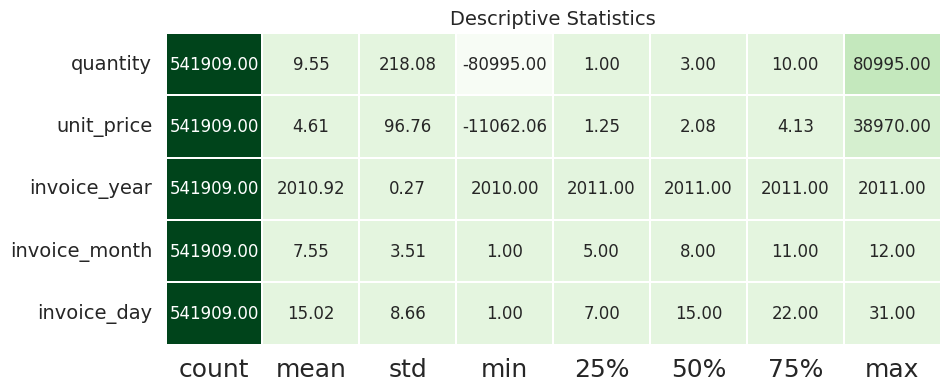

In [132]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Greens",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(df_LTV_01.select_dtypes(include = [float, int]))

* 취소된 주문내역 때문에 quantity < 0인 row 존재 
* total_price = quantity * unit_price로 구할 예정 

## 2.1 unit_price, quantity에 대한 확인 
- quantity < 0 인 부분 확인  
- stock_code가 같은데도 unit_price가 다른 경우에 대한 확인 

In [133]:
df_LTV_01[df_LTV_01['quantity'] < 0].sample(5)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
492135,C578090,POST,-2,2011-11-22 17:03:00,40.00,12483,2011,11,22
488515,C577832,84988,-12,2011-11-22 10:18:00,1.45,18274,2011,11,22
173848,551722,20975,-170,2011-05-03 16:50:00,0.00,0,2011,5,3
259862,C559747,85159A,-5,2011-07-12 11:23:00,1.95,17069,2011,7,12
146606,549006,84508B,-23,2011-04-05 14:38:00,0.00,0,2011,4,5


In [134]:
# pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.
# pd.set_option('display.max_rows', None) ## 모든 열을 출력한다.

In [135]:
# df_LTV_01[df_LTV_01['customer_id'] == 12471] # quantity < 0인 행이 있는 customer 확인 

- invoice_no 가장 앞에 C가 있으면 취소한 내역, 취소했을 시 quantity < 0 
- but, C 뒤 번호로 어떤 내역을 취소한 건지 확인 불가 (해당하는 invoice_no 없음) 

우리는 구매 내역만 필요한 거니까 그냥 무시하고 total_price 계산해도 될 듯?? 
quantity < 0 인 경우를 확인해보자. 

In [136]:
df_LTV_01[df_LTV_01['unit_price'] == 0].sample(5) # unit_price == 0인 경우 확인 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
108687,545565,47563B,-10,2011-03-03 16:14:00,0.0,0,2011,3,3
136272,547957,20713,32,2011-03-28 15:16:00,0.0,0,2011,3,28
432675,573885,22689,40,2011-11-01 13:26:00,0.0,0,2011,11,1
65876,541697,21632,8,2011-01-20 18:09:00,0.0,0,2011,1,20
64321,541601,22632,-84,2011-01-19 16:48:00,0.0,0,2011,1,19


In [137]:
print((df_LTV_01[df_LTV_01['unit_price'] == 0].shape)) 
print((df_LTV_01[df_LTV_01['customer_id'] == 0].shape))

print((df_LTV_01[(df_LTV_01['customer_id'] == 0) & (df_LTV_01['unit_price'] == 0)].shape))

(2515, 9)
(0, 9)
(0, 9)


In [138]:
df_LTV_01[ (df_LTV_01['unit_price'] == 0) & (df_LTV_01['customer_id'] != 0) ]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
622,536414,22139,56,2010-12-01 11:52:00,0.0,0,2010,12,1
1970,536545,21134,1,2010-12-01 14:32:00,0.0,0,2010,12,1
1971,536546,22145,1,2010-12-01 14:33:00,0.0,0,2010,12,1
1972,536547,37509,1,2010-12-01 14:33:00,0.0,0,2010,12,1
1987,536549,85226A,1,2010-12-01 14:34:00,0.0,0,2010,12,1
1988,536550,85044,1,2010-12-01 14:34:00,0.0,0,2010,12,1
2024,536552,20950,1,2010-12-01 14:34:00,0.0,0,2010,12,1
2025,536553,37461,3,2010-12-01 14:35:00,0.0,0,2010,12,1
2026,536554,84670,23,2010-12-01 14:35:00,0.0,0,2010,12,1
2406,536589,21777,-10,2010-12-01 16:50:00,0.0,0,2010,12,1


In [139]:
df_base[df_base['stock_code'] == '22034'] # unit_price == 0 인 상품 확인 

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
8828,537153,22034,ROBIN CHRISTMAS CARD,3,12/5/2010 13:03,0.42,16718.0,United Kingdom
19996,537999,22034,NaN,-223,12/9/2010 11:44,0.00,NaN,United Kingdom
35347,539436,22034,ROBIN CHRISTMAS CARD,5,12/17/2010 14:49,0.42,NaN,United Kingdom
44297,C540164,22034,ROBIN CHRISTMAS CARD,-12,1/5/2011 12:02,0.42,14911.0,EIRE
243332,558445,22034,NaN,-18,6/29/2011 13:39,0.00,NaN,United Kingdom
270602,560578,22034,NaN,12,7/19/2011 15:12,0.00,NaN,United Kingdom
469110,576580,22034,NaN,-5,11/15/2011 14:15,0.00,NaN,United Kingdom
490649,578065,22034,ROBIN CHRISTMAS CARD,1,11/22/2011 15:41,0.83,NaN,United Kingdom
501878,578833,22034,ROBIN CHRISTMAS CARD,1,11/25/2011 15:23,0.83,NaN,United Kingdom


- unit_price = 0인 이유에 대해 확정짓기 어려움 

    - 같은 stock_code인데도 unit_price = 0 인 경우 존재 
    -  unit_price = 0 인 경우 중 customer_id이 NaN이었던 경우가 대부분이긴 했으나, 이유를 추측하기 어려움 


**추측**
1.   단기성 이벤트로 해당 상품을 무료로 증정한 적이 있었다 
2.   프로모션이 진행됨에 따라 같은 stock_code여도 unit_price가 다를 수 있다 

어차피 unit_price = 0 인 경우에 대해서는 total_price = 0 이지만 구매 횟수에 영향을 줄 수 있으므로 남겨둔다. 
하지만 quantity < 0 인 경우는 구매가 아니므로 분리할 필요가 있음 

## 2.2 unit_price, quantity에 대한 추가 전처리 
- quantity < 0 인 경우 drop (row 수: 75106 -> 73594) 


In [140]:
## rollback을 위해 copy 
df_LTV_02 = df_LTV_01[df_LTV_01['quantity'] > 0]

In [141]:
## total_price = quantity * unit_price 열 추가 
df_LTV_02['total_price'] = df_LTV_02['quantity'] * df_LTV_02['unit_price']

In [142]:
df_LTV_01.shape

(541909, 9)

In [143]:
df_LTV_02.shape

(531285, 10)

In [146]:
## customer_id == '0'인 경우 drop 
df_LTV_02 = df_LTV_02[ df_LTV_02['customer_id'] != '0']

In [147]:
df_LTV_02.shape

(397924, 10)

In [148]:
df_LTV_02.info() # 최종 LTV 계산에 활용할 데이터 형태 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   invoice_no     397924 non-null  object        
 1   stock_code     397924 non-null  object        
 2   quantity       397924 non-null  int64         
 3   invoice_date   397924 non-null  datetime64[ns]
 4   unit_price     397924 non-null  float64       
 5   customer_id    397924 non-null  object        
 6   invoice_year   397924 non-null  int64         
 7   invoice_month  397924 non-null  int64         
 8   invoice_day    397924 non-null  int64         
 9   total_price    397924 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 33.4+ MB


#_3. Life Time Value (고객 생애가치) 계산 